In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange

from general_functions import sqrt_err_relative, check_coo_tensor, gen_coo_tensor

In [2]:
@jit(nopython=True)
def generate_system(coo_tensor, vals, shape, mode, a, b, l2, step):
    mtx = np.zeros((a.shape[1], a.shape[1]))
    right = np.zeros((a.shape[1]))
    coo_step = coo_tensor[coo_tensor[:, mode] == step]
    
    if mode == 0:
        mode_a = 1 
        mode_b = 2
        
    elif mode == 1:
        mode_a = 0
        mode_b = 2
        
    else:
        mode_a = 0
        mode_b = 1
        
    for i in range(a.shape[1]):
        for j in range(a.shape[1]):
            for item in range(coo_step.shape[0]):
                coord = coo_step[item]
                mtx[i, j] += (a[coord[mode_a], i] 
                              * b[coord[mode_b], i] 
                              * a[coord[mode_a], j] 
                              * b[coord[mode_b], j])
                if i == 0:
                    right[j] += a[coord[mode_a], j] * b[coord[mode_b], j] * vals[item]
            
            if i == j:
                mtx[i, j] += l2
    
    return mtx, right

In [127]:
@jit(nopython=True) 
def wrcp_als3(coo_tensor,
              vals,
              shape,
              rank=5,
              l2=0.5,
              max_iter=50,
              tol=1e-8):
    
    a = np.random.rand(shape[0], rank)
    b = np.random.rand(shape[1], rank)
    c = np.random.rand(shape[2], rank)
    err_arr = np.empty((max_iter, 1))  
    
    it = 0
    err1 = 1.0
    err2 = 0.0
    while np.abs(err1 - err2) > tol:
        it += 1
        
        for i in range(shape[0]):
            A, right = generate_system(coo_tensor,
                                       vals,
                                       shape,
                                       0,
                                       b,
                                       c, 
                                       l2,
                                       i)
            
            a[i, :] = np.linalg.pinv(A) @ right
            #a[i, :] = np.linalg.solve(A, right)
            
        for j in range(shape[1]):
            A, right = generate_system(coo_tensor,
                                       vals,
                                       shape,
                                       1,
                                       a,
                                       c, 
                                       l2,
                                       j)
            
            b[j :] = np.linalg.pinv(A) @ right
            #b[j :] = np.linalg.solve(A, right)
            
        for k in range(shape[2]):   
            A, right = generate_system(coo_tensor,
                                       vals,
                                       shape,
                                       2,
                                       a,
                                       b, 
                                       l2,
                                       k)
            
            c[k, :] = np.linalg.pinv(A) @ right
            #c[k, :] = np.linalg.solve(A, right)
    
        error = sqrt_err_relative(coo_tensor, vals, shape, a, b, c)
        err_arr[it - 1] = error
        err2 = err1
        err1 = error
        if it == max_iter:
            print("iterations over")
            break
    
    return a, b, c, err_arr

## Random Matrix

In [6]:
%%time
init_shape = (10, 20, 30)
coo, vals = gen_coo_tensor(init_shape, density=0.02)
assert check_coo_tensor(coo)!= "Bad"

CPU times: user 2.42 ms, sys: 0 ns, total: 2.42 ms
Wall time: 4.39 ms


In [7]:
coo.shape[0]

120

In [149]:
%%time
max_iter = 12
rank = 40
a, b, c, err = wrcp_als3(coo, vals, init_shape, rank=rank, l2=0.9, max_iter=max_iter)

iterations over
CPU times: user 366 ms, sys: 24 ms, total: 390 ms
Wall time: 222 ms


In [150]:
rerror = sqrt_err_relative(coo, vals, init_shape, a, b, c)
print(f"Rel err = {rerror};")

Rel err = 1.9547440228145752;


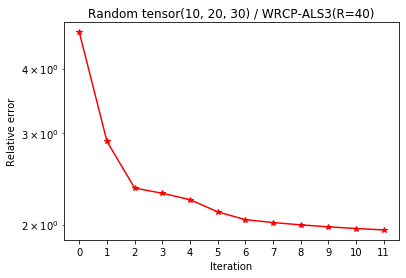

In [151]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Random tensor{init_shape} / WRCP-ALS3(R={rank})")
plt.xticks(np.arange(max_iter))
plt.yscale("log")
plt.plot(np.arange(max_iter), err[:max_iter], 'r-*')

## Small Rank Matrix

In [152]:
shape = (5, 7, 9)
rank = 3
ten = np.zeros(shape=shape)
p = np.zeros(shape=(shape[0], rank))
q = np.zeros(shape=(shape[1], rank))
r = np.zeros(shape=(shape[2], rank))
all_elem = np.prod(shape)
all_elem

315

In [153]:
p[0] = [1, 0, 0]
p[1] = [0, 1, 0]
p[2] = [0, 0, 1]

q[0] = [1, 0, 0]
q[1] = [0, 1, 0]
q[2] = [0, 0, 1]

r[0] = [1, 0, 0]
r[1] = [0, 1, 0]
r[2] = [0, 0, 1]

p[3] = [1, 1, 1]
q[3] = [1, 0, 1]
r[3] = [1, 0, 1]

p[4] = [1, 1, 1]
q[5] = [1, 0, 1]
r[6] = [1, 0, 1]

In [154]:
coo = list()
vals = list()
nnz = 0
for i in range(shape[0]):
    for j in range(shape[1]):
        for k in range(shape[2]):
            temp = np.sum(p[i, :] * q[j, :] * r[k, :])
            ten[i, j, k] = temp
            if temp != 0:
                vals.append(temp)
                coo.append((i, j, k))
                nnz += 1
coo = np.array(coo)
vals = np.array(vals)

In [155]:
nnz

49

In [302]:
%%time
max_iter = 10
rank = 3
a, b, c, err = wrcp_als3(coo, vals, shape, rank=rank, l2=0, max_iter=max_iter)

iterations over
CPU times: user 6.36 ms, sys: 47 µs, total: 6.4 ms
Wall time: 7.16 ms


In [303]:
rerror = sqrt_err_relative(coo, vals, init_shape, a, b, c)
print(f"Rel err = {rerror};")

Rel err = 0.938725251123111;


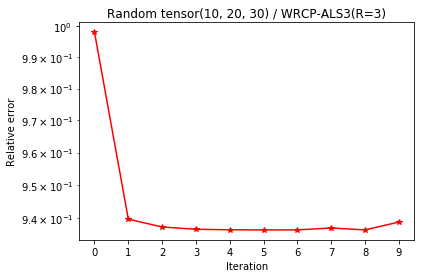

In [304]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Random tensor{init_shape} / WRCP-ALS3(R={rank})")
plt.xticks(np.arange(max_iter))
plt.yscale("log")
plt.plot(np.arange(max_iter), err[:max_iter], 'r-*')

In [168]:
import tensorly as tl
from tensorly.decomposition import parafac

In [305]:
_, f = parafac(ten, 3, init="random", random_state=1)

In [306]:
rerror = sqrt_err_relative(coo, vals, init_shape, f[0], f[1], f[2])
print(f"Rel err = {rerror};")

Rel err = 1.1641833883783917e-07;


In [187]:
import CP_ALS3 as cp

In [315]:
%%time
max_iter = 15
rank = 3
a, b, c, err = cp.cp_als3(coo, vals, shape, rank=rank, max_iter=max_iter)

iterations over
CPU times: user 3.35 ms, sys: 0 ns, total: 3.35 ms
Wall time: 3.35 ms


In [316]:
rerror = sqrt_err_relative(coo, vals, init_shape, a, b, c)
print(f"Rel err = {rerror};")

Rel err = 0.009859650497655362;


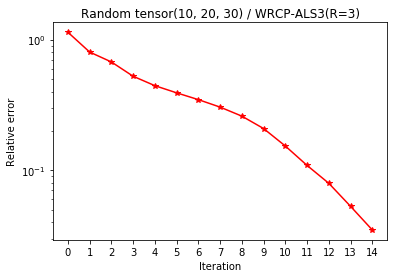

In [211]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Random tensor{init_shape} / WRCP-ALS3(R={rank})")
plt.xticks(np.arange(max_iter))
plt.yscale("log")
plt.plot(np.arange(max_iter), err[:max_iter], 'r-*')